[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/devdastl/EVA-8_Phase-1_Assignment-13/blob/main/Part1-Unet-implementation/StrideConv_TransConv_Dice.ipynb)

### Implementation-4: 
Notebook `EVA-8_Phase-1_Assignment-13\Part1-Unet-implementation\StrideConv_TransConv_Dice.ipynb` contains the fourth implementation of UNET.
<br> 
Below ar the creteria for the fourth implementation:
 - Strided-Convolution for reduction
 - Transpose-Convolution for upscaling 
 - Dice loss for loss calculation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    #transforms.Normalize()
])

target_transform = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Resize((128,128)),

])

In [3]:
#dataset = torchvision.datasets.OxfordIIITPet(root='./data', target_types='segmentation', download=True, transform=data_transform, target_transform=target_transform)
dataset_raw = torchvision.datasets.OxfordIIITPet(root='./data', target_types='segmentation', download=True, transform=data_transform, target_transform=target_transform)

In [4]:
class custom_dataset():
  def __init__(self, dataset):
    self.datasets = dataset

  def __len__(self):
    return len(self.datasets)

  def __getitem__(self, index):
    img = self.datasets[index][0]
    mask = torch.from_numpy(np.array(self.datasets[index][1])) 
    mask -=1
    mask = torch.nn.functional.one_hot(mask.to(torch.int64), 3)
    return img, mask.permute(2,0,1)

In [5]:
dataset = custom_dataset(dataset_raw)
print(dataset[10][0].shape)
img = (dataset[10][1])
print(img[:,64,:])


torch.Size([3, 128, 128])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 

In [6]:
labels_again = torch.argmax(img, dim=0)
print(labels_again[64,:])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [7]:
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader

split_ratio = 0.8
random_seed = 1234
num_samples = len(dataset)
indices = np.arange(num_samples)

np.random.seed(random_seed)
np.random.shuffle(indices)

num_train_samples = int(num_samples * split_ratio)
num_test_samples = num_samples - num_train_samples

# Split the indices into train and test subsets
train_indices = indices[:num_train_samples]
test_indices = indices[num_train_samples:]

# Print the number of samples in each subset
print(f"Number of train samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")

# Create the train and test subsets using the Subset class
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

Number of train samples: 2944
Number of test samples: 736


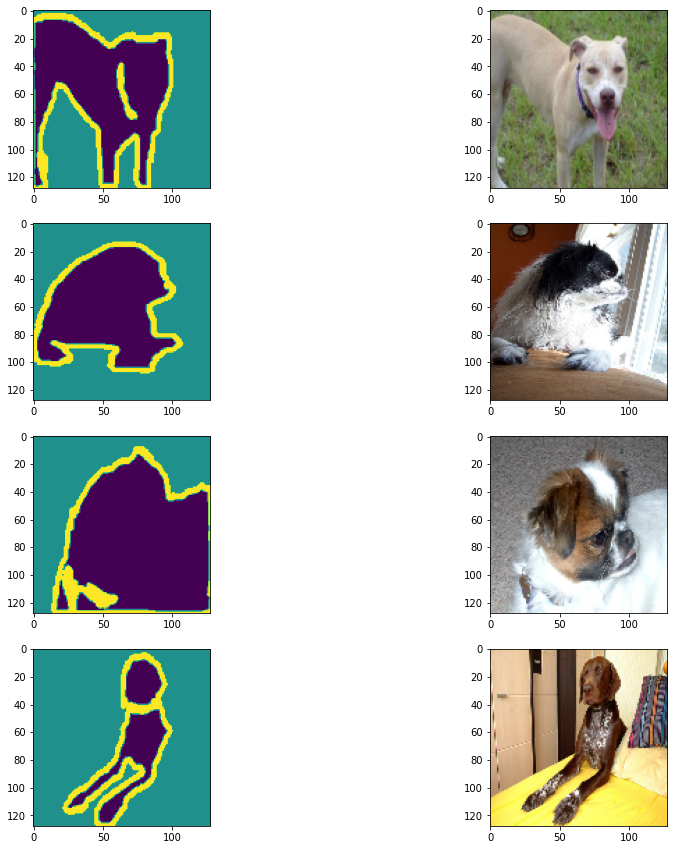

In [8]:
import imageio
from PIL import Image
import numpy as np
#print(np.unique(train_subset[][1]))


# for visualizations
import matplotlib.pyplot as plt
fig, arr = plt.subplots(4, 2, figsize=(15, 15))
for i in range(0,4):
  mask_view = torch.argmax(train_subset[i][1], dim=0)
  #print(mask_view.shape))
 
  
  arr[i][0].imshow(mask_view)
  arr[i][1].imshow((train_subset[i][0]).permute(1,2,0))

code to get normalization values

In [9]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=True)

In [10]:
len(test_loader.dataset)

736

### Build U-NET architecture

#### Encoder part
Here also we are using Strided convolution

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):

  def __init__(self, in_channel, out_channel, dropout_prob=0.1, max_pooling=True):

    self.max_pooling = max_pooling
    super(EncoderBlock, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding='same'),
                               nn.BatchNorm2d(out_channel),
                               nn.ReLU(),
                               nn.Dropout(dropout_prob)
                                )
    self.conv2 = nn.Sequential(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding='same'),
                               nn.BatchNorm2d(out_channel),
                               nn.ReLU(),
                               nn.Dropout(dropout_prob)
                                )
    if max_pooling:
      #self.pool = nn.MaxPool2d(2,2)
      self.pool = nn.Sequential(nn.Conv2d(out_channel, out_channel, kernel_size=2, stride=2, padding='valid'),
                               nn.BatchNorm2d(out_channel),
                               nn.ReLU(),
                               nn.Dropout(dropout_prob)
                                )


  def forward(self, input):

    conv = self.conv2(self.conv1(input))
    if self.max_pooling:
      next = self.pool(conv)
    else:
      next = conv
    skip = conv

    return next, skip


In [12]:
from torchsummary import summary
test = EncoderBlock(in_channel=3, out_channel=128)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = test.to(device)
summary(my_model1, input_size=(3,32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
       BatchNorm2d-2          [-1, 128, 32, 32]             256
              ReLU-3          [-1, 128, 32, 32]               0
           Dropout-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]         147,584
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
           Dropout-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]          65,664
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
Total params: 217,600
Trainable params: 217,600
Non-trainable params: 0
--------------------------

#### Decoder part

In [13]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channel, out_channel, dropout_prob=0.1):
    super(DecoderBlock,self).__init__()
    self.trans_conv1 = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2 ,stride=2)
    self.conv1 = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding='same'),
                               nn.BatchNorm2d(out_channel),
                               nn.ReLU(),
                               nn.Dropout(dropout_prob))
    self.conv2 = nn.Sequential(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding='same'),
                               nn.BatchNorm2d(out_channel),
                               nn.ReLU(),
                               nn.Dropout(dropout_prob))
  def forward(self, input, skip):
    up = self.trans_conv1(input)
    merge = torch.cat([up, skip], dim=1)
    conv = self.conv2(self.conv1(merge))
    return conv


In [14]:
from torchsummary import summary
test_2 = DecoderBlock(in_channel=256, out_channel=128)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = test_2.to(device)
summary(my_model1, input_size=[(256,32, 32), (128, 64, 64)])

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 128, 64, 64]         131,200
            Conv2d-2          [-1, 128, 64, 64]         295,040
       BatchNorm2d-3          [-1, 128, 64, 64]             256
              ReLU-4          [-1, 128, 64, 64]               0
           Dropout-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]         147,584
       BatchNorm2d-7          [-1, 128, 64, 64]             256
              ReLU-8          [-1, 128, 64, 64]               0
           Dropout-9          [-1, 128, 64, 64]               0
Total params: 574,336
Trainable params: 574,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 524288.00
Forward/backward pass size (MB): 36.00
Params size (MB): 2.19
Estimated Total Size (MB): 524326.19
---------------------------

In [15]:
class Unet(nn.Module):
  def __init__(self, n_classes=3, in_channel=3, out_channel = 32):
    self.n_classes = n_classes
    super(Unet, self).__init__()

    # initialize encode block
    self.encode1 = EncoderBlock(in_channel, out_channel)
    self.encode2 = EncoderBlock(out_channel, out_channel*2)
    self.encode3 = EncoderBlock(out_channel*2, out_channel*4)
    self.encode4 = EncoderBlock(out_channel*4, out_channel*8)
    self.encode5 = EncoderBlock(out_channel*8, out_channel*16, max_pooling=False)

    #initialize decode block
    self.decode1 = DecoderBlock(in_channel=out_channel*16, out_channel=out_channel*8)
    self.decode2 = DecoderBlock(in_channel=out_channel*8, out_channel=out_channel*4)
    self.decode3 = DecoderBlock(in_channel=out_channel*4, out_channel=out_channel*2)
    self.decode4 = DecoderBlock(in_channel=out_channel*2, out_channel=out_channel)

    #num channesl
    self.conv1 = nn.Sequential(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding='same')
                               )
    self.conv2 = nn.Conv2d(out_channel, self.n_classes, kernel_size=1, padding='same')

  def forward(self, input):
    #encode block
    layer1 = self.encode1(input)
    layer2 = self.encode2(layer1[0])
    layer3 = self.encode3(layer2[0])
    layer4 = self.encode4(layer3[0])
    layer5 = self.encode5(layer4[0])

    #decoce block
    layer6 = self.decode1(layer5[0], layer4[1])
    layer7 = self.decode2(layer6, layer3[1])
    layer8 = self.decode3(layer7, layer2[1])
    layer9 = self.decode4(layer8, layer1[1])

    layer10 = self.conv2(self.conv1(layer9))

    return layer10


In [16]:
from torchsummary import summary
test_3 = Unet()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = test_3.to(device)
summary(my_model1, input_size=(3,128, 128))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
           Dropout-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           9,248
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
           Dropout-8         [-1, 32, 128, 128]               0
            Conv2d-9           [-1, 32, 64, 64]           4,128
      BatchNorm2d-10           [-1, 32, 64, 64]              64
             ReLU-11           [-1, 32, 64, 64]               0
          Dropout-12           [-1, 32, 64, 64]               0
     EncoderBlock-13  [[-1, 32, 64, 64], [-1, 32, 128, 128]]               0
           Conv2d-14 

In [17]:
class DiceLoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
      super(DiceLoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):
      
      #comment out if your model contains a sigmoid or equivalent activation layer
      inputs = F.softmax(inputs, dim=1)       
      
      #flatten label and prediction tensors
      inputs = inputs.view(-1)
      targets = targets.view(-1)
      
      intersection = (inputs * targets).sum()                            
      dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
      
      return 1 - dice

In [18]:
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 1e-5
amp = False
weight_decay = 1e-8
momentum = 0.999
epochs = 10
gradient_clipping = 1.0

model = Unet(n_classes = 3)
model = model.to(device=device)

optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
global_step = 0

# function to train and evaluate 
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch, criterion, dice_loss, losses, accuracys):
    model.train()
    pbar = tqdm(train_loader)
    running_loss = 0
    total_train = 0
    correct_train = 0
    for batch_idx, (data, target) in enumerate(pbar):
        images, true_masks = data.to(device), (target.to(torch.float32)).to(device)

        
        with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
          masks_pred = model(images)
          if model.n_classes == 1:
                #using dice loss
              loss = dice_loss(masks_pred.squeeze(1), true_masks.float())

          else:
                loss = dice_loss(masks_pred, true_masks)

        optimizer.zero_grad()
        running_loss += loss
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()

        pred = torch.argmax(masks_pred, dim=1)
        true_masks = torch.argmax(true_masks, dim=1)
        total_train += true_masks.nelement()
        correct_train += pred.eq(true_masks).sum().item()
        train_accuracy = 100 * correct_train / total_train
        
        losses.append(loss.item())
        accuracys.append(train_accuracy)
        pbar.set_description(desc= f'(Dice) loss={loss.item()} batch_id={batch_idx}, train-accuracy={train_accuracy}')


def test(model, device, test_loader, criterion, dice_loss):
    model.eval()
    test_loss = 0
    correct = 0
    total_test = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), (target.to(torch.float32)).to(device)

            output = model(data)
            #using dice loss
            loss = dice_loss(output, target)
            test_loss += loss.item()  # sum up batch loss

            pred = (output).argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
            target = torch.argmax(target, dim=1).squeeze()

            total_test += target.nelement()
            correct += pred.eq(target).sum().item()

    test_loss /= 64

    print('\nTest set: Average (Dice) loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, total_test,
        100. * correct /total_test))

In [19]:
# epochs 
import torch.optim as optim
accum_loss = []
accum_acc = []

for epoch in range(1, 26):
    train(model, device, train_loader, optimizer, epoch, criterion, dice_loss, accum_loss, accum_acc)
    test(model, device, test_loader, criterion, dice_loss)

(Dice) loss=0.2960817813873291 batch_id=45, train-accuracy=64.45335305255



Test set: Average (Dice) loss: 0.0593, Accuracy: 8239282/12058624 (68.3269%)



(Dice) loss=0.2679539918899536 batch_id=45, train-accuracy=72.98321723937



Test set: Average (Dice) loss: 0.0540, Accuracy: 8587269/12058624 (71.2127%)



(Dice) loss=0.2525607943534851 batch_id=45, train-accuracy=73.93820596777



Test set: Average (Dice) loss: 0.0501, Accuracy: 8849611/12058624 (73.3882%)



(Dice) loss=0.24705910682678223 batch_id=45, train-accuracy=74.5843327563



Test set: Average (Dice) loss: 0.0494, Accuracy: 8863807/12058624 (73.5060%)



(Dice) loss=0.2333506941795349 batch_id=45, train-accuracy=75.16882937887



Test set: Average (Dice) loss: 0.0457, Accuracy: 9125795/12058624 (75.6786%)



(Dice) loss=0.23550617694854736 batch_id=45, train-accuracy=75.8692388949



Test set: Average (Dice) loss: 0.0453, Accuracy: 9142257/12058624 (75.8151%)



(Dice) loss=0.24317532777786255 batch_id=45, train-accuracy=76.2870394665



Test set: Average (Dice) loss: 0.0446, Accuracy: 9195407/12058624 (76.2559%)



(Dice) loss=0.23538023233413696 batch_id=45, train-accuracy=76.6929895981



Test set: Average (Dice) loss: 0.0437, Accuracy: 9254204/12058624 (76.7434%)



(Dice) loss=0.21408367156982422 batch_id=45, train-accuracy=76.8596047940



Test set: Average (Dice) loss: 0.0432, Accuracy: 9273535/12058624 (76.9038%)



(Dice) loss=0.2214120626449585 batch_id=45, train-accuracy=77.28570233220



Test set: Average (Dice) loss: 0.0452, Accuracy: 9151865/12058624 (75.8948%)



(Dice) loss=0.20918762683868408 batch_id=45, train-accuracy=77.5753187096



Test set: Average (Dice) loss: 0.0433, Accuracy: 9270164/12058624 (76.8758%)



(Dice) loss=0.23222434520721436 batch_id=45, train-accuracy=77.7890122455



Test set: Average (Dice) loss: 0.0420, Accuracy: 9362959/12058624 (77.6453%)



(Dice) loss=0.22323626279830933 batch_id=45, train-accuracy=78.1527187513



Test set: Average (Dice) loss: 0.0411, Accuracy: 9413220/12058624 (78.0621%)



(Dice) loss=0.21770668029785156 batch_id=45, train-accuracy=78.4939724466



Test set: Average (Dice) loss: 0.0407, Accuracy: 9430617/12058624 (78.2064%)



(Dice) loss=0.22103095054626465 batch_id=45, train-accuracy=78.5553082175



Test set: Average (Dice) loss: 0.0409, Accuracy: 9436438/12058624 (78.2547%)



(Dice) loss=0.20635324716567993 batch_id=45, train-accuracy=78.8638488106



Test set: Average (Dice) loss: 0.0401, Accuracy: 9485561/12058624 (78.6621%)



(Dice) loss=0.19637811183929443 batch_id=45, train-accuracy=79.1060634281



Test set: Average (Dice) loss: 0.0401, Accuracy: 9482387/12058624 (78.6357%)



(Dice) loss=0.21040737628936768 batch_id=45, train-accuracy=79.4301717177



Test set: Average (Dice) loss: 0.0388, Accuracy: 9568976/12058624 (79.3538%)



(Dice) loss=0.20388197898864746 batch_id=45, train-accuracy=79.3705297553



Test set: Average (Dice) loss: 0.0390, Accuracy: 9545094/12058624 (79.1557%)



(Dice) loss=0.19570541381835938 batch_id=45, train-accuracy=79.3607504471



Test set: Average (Dice) loss: 0.0390, Accuracy: 9561457/12058624 (79.2914%)



(Dice) loss=0.209905743598938 batch_id=45, train-accuracy=79.590063509733



Test set: Average (Dice) loss: 0.0395, Accuracy: 9517962/12058624 (78.9307%)



(Dice) loss=0.19044268131256104 batch_id=45, train-accuracy=79.5790900354



Test set: Average (Dice) loss: 0.0394, Accuracy: 9535184/12058624 (79.0736%)



(Dice) loss=0.20295411348342896 batch_id=45, train-accuracy=79.5541701109



Test set: Average (Dice) loss: 0.0396, Accuracy: 9504290/12058624 (78.8174%)



(Dice) loss=0.21319591999053955 batch_id=45, train-accuracy=79.6415909476



Test set: Average (Dice) loss: 0.0390, Accuracy: 9542653/12058624 (79.1355%)



(Dice) loss=0.1827639937400818 batch_id=45, train-accuracy=79.60314128709



Test set: Average (Dice) loss: 0.0385, Accuracy: 9579766/12058624 (79.4433%)



In [20]:
image = [test_subset[i+10][0].unsqueeze(0) for i in range(1,5)]
label_true = [test_subset[i+10][1].squeeze().permute(1,2,0).argmax(dim=2).float() for i in range(1,5)]
print(image[1].shape)
print(label_true[1])

torch.Size([1, 3, 128, 128])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


In [21]:
model.eval()
pred = []
for img in image:
    with torch.no_grad():
        pred.append(model(img.to('cuda')))


In [22]:

pred = [torch.argmax(p, dim=1).permute(1,2,0).squeeze() for p in pred]
array_pred = [np.array(p.to('cpu')) for p in pred]


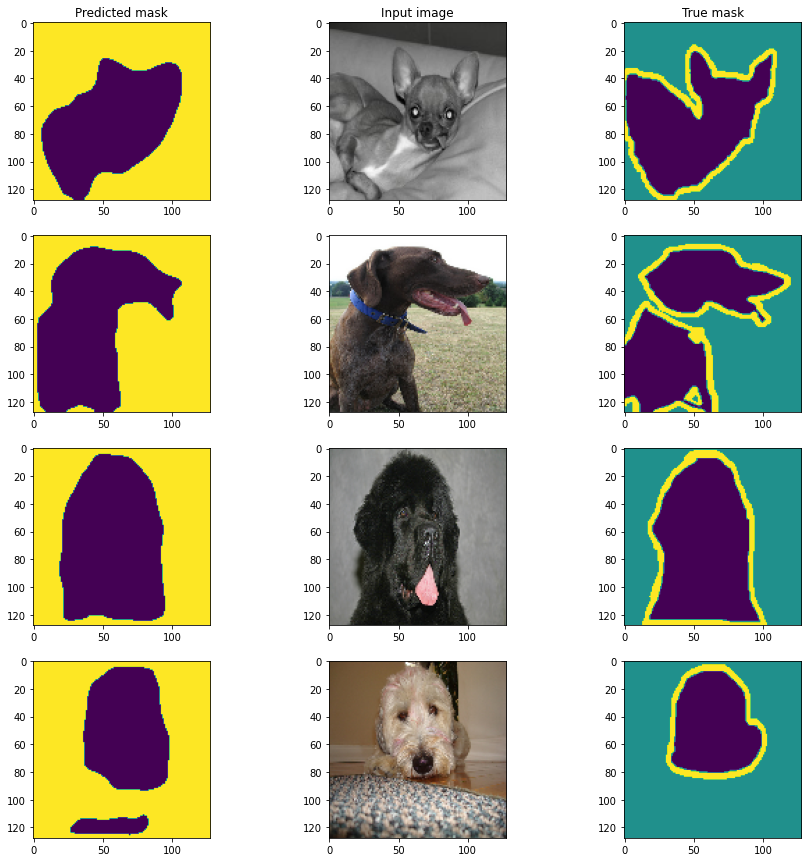

In [23]:
import imageio
from PIL import Image
import numpy as np



# for visualizations
import matplotlib.pyplot as plt
fig, arr = plt.subplots(4, 3, figsize=(15, 15))
arr[0][0].set_title('Predicted mask')
arr[0][1].set_title('Input image')
arr[0][2].set_title('True mask')
for i,p in enumerate(array_pred):
    arr[i][0].imshow(p*255)
    arr[i][1].imshow(np.array(image[i].squeeze().permute(1,2,0)))
    arr[i][2].imshow(np.array(label_true[i])*255)



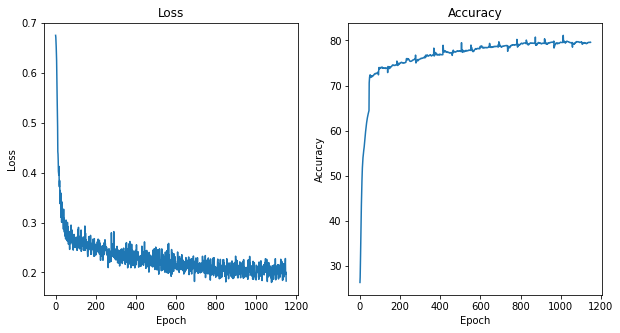

In [24]:
import matplotlib.pyplot as plt

# Sample data
loss = accum_loss
accuracy = accum_acc

# Set up figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot loss on the first subplot
axs[0].plot(loss)
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# Plot accuracy on the second subplot
axs[1].plot(accuracy)
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

# Show the plot
plt.show()